# GPT-2 Fine-Tuning Tutorial using raw text corpus

From Rey Farhan (https://reyfarhan.com/posts/easy-gpt2-finetuning-huggingface/)




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch on raw data. 

---------
Your task is to modify this assignment on raw text of your choice (I have put Pride and Prejudice as an example below) and include 10 sample generations from your chosen text that you find interesting. 


# Setup

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 12.9 MB/s 
     |████████████████████████████████| 895 kB 43.2 MB/s 
     |████████████████████████████████| 6.6 MB 45.9 MB/s 
     |████████████████████████████████| 596 kB 20.5 MB/s 
     |████████████████████████████████| 77 kB 5.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!nvidia-smi

Thu Apr 14 05:20:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Training Set


In [ ]:
# mount my Google Drive directory and access the training data located there
gdrive_dir = '/content/gdrive/'
data_dir = os.path.join(gdrive_dir, "'My Drive'")
filename = 'prideAndPrejudice.txt'

drive.mount(gdrive_dir, force_remount=True)


Mounted at /content/gdrive/


In [ ]:
# copy the data to the current Colab working directory
!cp $data_dir/$filename .

In [ ]:
f=open(filename)
docs=f.readlines()
docs=[b.strip() for b in docs]
docs[:5]

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


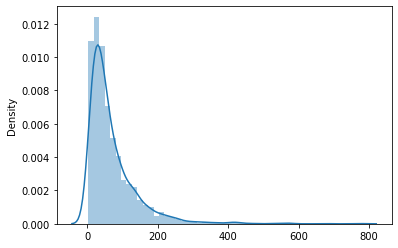

In [ ]:
doc_lengths = []

for doc in docs:

    # get rough token count distribution
    tokens = nltk.word_tokenize(doc)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [ ]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0004847309743092584

In [ ]:
np.average(doc_lengths)

69.48715462918081

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most lines will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [ ]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [ ]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each line in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the line is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the line is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [ ]:
dataset = GPT2Dataset(docs, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,856 training samples
  207 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [ ]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    928. Loss: 0.42047443985939026.   Elapsed: 0:01:42.
0:  bipartisanIn such a way, it will do nothing to alleviate your anguish:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    928. Loss: 0.24508878588676453.   Elapsed: 0:03:23.
0:  increasingThe next moment the man took place opposite the door and joined them immediately, but soon after left them and drove them to the back of a house. I found him, standing at the entrance of the street, alone. The young person, who never entered, was very much frightened for the sake of my own feelings of being afraid of him. His eyes were fixed on me when he heard the voice on the hall- door. This was very much better than any I had ever heard in my life. The carriage to Longbourn was quite ill!I told him I was sorry to introduce this stranger to Mr. Collins, who was more civility in talking to them; and I went to meet him soon afterwards on my way to Brighton, and we were soon back again.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    928. Loss: 0.3002447783946991.   Elapsed: 0:05:07.
0: dayIn the morning, Jane sat down to make supper; and Miss Bingley, whom now sat down to receive her, made the following remarks to herself--


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    928. Loss: 0.36035865545272827.   Elapsed: 0:06:48.
0:  Hang"Oh, sir," she added, "but how could you have been more than I was in love with him? How was he to know that me was not? How could he have been so indifferent to my happiness? How could he have wished me to have been at the wedding so often?"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    928. Loss: 0.3130340278148651.   Elapsed: 0:08:31.
0:  foods"That is the whole manner of it. They are so much in disarray, they cannot be more perfect than they have been. But if, with a rational inclination and heart, she would still be in it, it was never her doing."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    928. Loss: 0.1732451617717743.   Elapsed: 0:10:12.
0:  trail"Yes, ma'am," added Kitty to herself, as she entered the house.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    928. Loss: 0.2746277451515198.   Elapsed: 0:11:54.
0: intend"My sister, I will be happy to be able to tell you the truth from what I have known in Derbyshire since I saw your sister."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    928. Loss: 0.3104966878890991.   Elapsed: 0:13:35.
0:  surroundThe carriage, which brought with it a young Jane, was very large; she was more than a little ashamed of the size of it, and she resolved to have at least a few minutes by themselves in order to hear some of its particulars, when Bingley arrived. Mrs. Bennet was extremely desirous of attending to his attentions on the journey. She was determined, however, to hear no more of her sister's affairs, and was resolved to leave her. She was then joined by her wife, who was in earnest as to what was to be done, and who was quite satisfied with what was. Elizabeth's spirits were in her power. She did not dare say that she had ever heard of what had happened to Elizabeth; and she could hardly be quite comfortable. Mrs. Collins, though perfectly satisfied with what she had heard, though not in the least concerned about it, was ready to be of use. She was glad of the information, and thanked her husband,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of    928. Loss: 0.2740265130996704.   Elapsed: 0:15:19.
0:  reflex"Oh. I was supposed to have you here yesterday," replied the eldest. "I saw with astonishment when you sent in the letter in that kind of style, which is as much a disgrace to my sisters as the letter is to myself. I had not before seen you, from the first of the evening, in the library--and now I knew all the information. I had heard that the family would take you with them before they left town; but now I had to find out you, and find out what you have been to your father about the letter. How is your father to be in the habit of talking to you? If he would not come, you would think him an excellent nephew."

  Average training loss: 0.49
  Training epoch took: 0:15:50

Running Validation...
  Validation Loss: 0.32
  Validation took: 0:00:34

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    928. Loss: 0.07110421359539032.   Elapsed: 0:01:41.
0:  display"Perhaps," cried Mrs. Gardiner, "as a compliment to my aunt, who does not always speak to her with politeness but is not very well received by Mr. Bingley."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    928. Loss: 0.16355054080486298.   Elapsed: 0:03:22.
0:  pastor"I am not obliged to conclude that you are the same as this man, for I am very well aware that no one has ever described him. The subject does not appear here to suggest that any particular, which may easily disguise the character, had better been described, or at leastified, the whole person of Mr. Wickham."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    928. Loss: 0.12834756076335907.   Elapsed: 0:05:04.
0:  illicit"But it does give me pleasure," thought Lydia, "for I know you will be happy in doing it myself."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    928. Loss: 0.4694375693798065.   Elapsed: 0:06:44.
0:  Liberation"I am not acquainted with you," he added, "but perhaps I have been deceived."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    928. Loss: 0.49808984994888306.   Elapsed: 0:08:25.
0:  Nam"That my dear Charlotte, I could not but call your mother's name, would make her wish very certain. She was really my favourite daughter, and my favourite creature! But it does not always seem so, ma'am."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    928. Loss: 0.11057032644748688.   Elapsed: 0:10:06.
0: ION"He may as well call upon her."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    928. Loss: 0.2406046986579895.   Elapsed: 0:11:46.
0:  glimpse"It is not so pleasant a report. It does not take me very much time to learn of what has passed, and at length I hope to have more to say about it."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    928. Loss: 0.16247892379760742.   Elapsed: 0:13:27.
0:  LaureThe next morning was spent chiefly in the employments of Wickham, whose manners were always pleasing and unaffected; and he frequently visited Lady Catherine de Bourgh, and talked of her very ill health. At length it was over, and Mr. Bennet was admitted to the library. His aunt, the elder Bennets, and her daughters followed him upstairs, and the evening wore as it usually did. Mr. Darcy, who was particularly much engaged in reading, and talked to Jane, gave a great yawn to his sister, and gave directions to his library to promote reading; but he then turned over his library to the rest of the family, and gave directions to his library to the ladies, who, in general, were not too much engaged to follow him. His sister and Kitty had not time to wait on Jane; so their carriage stopped at the library.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of    928. Loss: 0.11292137205600739.   Elapsed: 0:15:11.
0: ism"No, dear lady," said Elizabeth, "I assure you not to make any excuse for yourself. It is very strange to hear of his staying at Netherfield this winter. There, and very inconvenient to me. You could not have prevented this from being done. You would not have danced with him at all. I am quite sure they would have danced at Netherfield as well; and so I hope they will like to have nothing but a comfortable home in their daughters. Lady Catherine and myself have not so easily got settled. I had not expected their going to be so. Let us go to the Lakes and Lakes at once. We have all the best education and everything to get. I beg your pardon, Mrs. Bennet, but you must feel it better than the others do. I have a fair reason to think that you must do better, and I wonder if your going to Scotland is in your favour. Mr. Phillips has done much for Netherfield," added her sister

  Average training loss: 0.30
  Tra

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    928. Loss: 0.4727541208267212.   Elapsed: 0:01:41.
0: oun"I must go immediately," said Miss Bingley.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    928. Loss: 0.1733999401330948.   Elapsed: 0:03:21.
0:  election"Why so?" said he, while turning away her book, "for you know, Mr. Collinsley is not a great reader."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    928. Loss: 0.18228402733802795.   Elapsed: 0:05:02.
0:  crazyElizabeth shook her head. "Oh, yes. She is a great deal more beautiful than Lydia."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    928. Loss: 0.4034479558467865.   Elapsed: 0:06:43.
0:  bench"When the gentlemen went away, I recollect them asking him whether he was glad to be staying in London. He replied to us with indifference, and, as I have already said, said that he had been the happiest man in the world, and that he had saved him from a most afflicting business. We were always looking for an acquaintance, and when you are out of the way for two or three weeks, you must learn to be cautious. But this time, I take you to the library, where you have prepared for all this unpleasant business. You may as well have ordered out your purchases as you choose. The only difference between _that_ shop and _this_ house of cards is in that you are more disposed of there than in the other rooms. Now, we are in great danger of running out of cards, because you have ordered a set of our own to go to Scotland, because we have already ordered a set of our own cards."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    928. Loss: 0.11136019229888916.   Elapsed: 0:08:26.
0:  incorporated"And is all it then to Mr. Phillips to refuse your renewal?"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    928. Loss: 0.18642903864383698.   Elapsed: 0:10:07.
0: Peter"No, no, it has not been. A report came from her, you know, about Jane. Who, that is, who, from whom, did she choose? We know, from sources at different quarters, that when she went to Brighton last November, Mr. Darcy asked her why she went there, and she answered by saying it was for her benefit to know that she was one of her sisters; that she was going somewhere, and Mr. Darcy looked at her with concern, and said, 'There, Jane, we will all be gone soon. It will not do,' said she, after a pause of several minutes. She then continued, "If I had no more money, it is _nothing_--nothing at all. Lydia, you know, has all the money. Well, Lizzy, you know, Jane's only money--all her neighbours are gone out for about a month."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    928. Loss: 0.2736894190311432.   Elapsed: 0:11:50.
0: uringElizabeth, taking her hand, said to Mr. Darcy,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    928. Loss: 0.09146428853273392.   Elapsed: 0:13:31.
0:  reproductive"In such cases, the writer will have no reserves for her judgement. This is exactly the case with regard to Mr. Darcy."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of    928. Loss: 0.22323523461818695.   Elapsed: 0:15:11.
0:  zone"This must be the case, Lizzy," cried her husband. "She says all this, and it is all settled."

  Average training loss: 0.25
  Training epoch took: 0:15:39

Running Validation...
  Validation Loss: 0.33
  Validation took: 0:00:34

======== Epoch 4 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    928. Loss: 0.6242632269859314.   Elapsed: 0:01:41.
0:  commits"And is that really all that settled?"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    928. Loss: 0.19966626167297363.   Elapsed: 0:03:21.
0:  irony"I have never seen him," said Darcy, after a short silence; "but he seems to have a very lively temper, and I suspect he is quite in love."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    928. Loss: 0.0943768247961998.   Elapsed: 0:05:02.
0:  Sah"My dear sir, you will not leave me for a twelvemonth."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    928. Loss: 0.21680234372615814.   Elapsed: 0:06:42.
0:  Bryan"I remember him fondly. He looked up to me as his brother, and looked at me with an expression of mingled astonishment and concern. He had never looked so proud as this before."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    928. Loss: 0.12522399425506592.   Elapsed: 0:08:23.
0:  spiritsShe looked pleased. "Yes, I do; but who would it be?"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    928. Loss: 0.2596626579761505.   Elapsed: 0:10:04.
0:  sees"My dear Jane!" cried Bingley; "it is a pity that you have been married so soon, or that your mother should not have to wait on you!"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    928. Loss: 0.12734538316726685.   Elapsed: 0:11:45.
0:  hungryElizabeth made no objection; they were engaged to go to Lucas Lodge, to Epsom, to shoot with the Lucases; when their visitor had called on their father, he immediately put himself forward to shoot in that part of the scene, but without the ceremony of an ensign.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    928. Loss: 0.3505431115627289.   Elapsed: 0:13:26.
0:  PT"I shall not be interrupted, my dear child," cried Kitty, "by your professions of love, affection, or confidence; or by my repeated assurances of intimacy, which I trust may yet be more fully proved by your information. You must understand, that by the end of the acquaintance, when Mr. Darcy goes away, I shall not receive him again, for we have only seen our only daughter."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of    928. Loss: 0.1802172213792801.   Elapsed: 0:15:07.
0: ü"I have no idea," replied she, "whether you have a very great dislike of me."

  Average training loss: 0.20
  Training epoch took: 0:15:35

Running Validation...
  Validation Loss: 0.35
  Validation took: 0:00:34

======== Epoch 5 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    928. Loss: 0.06368376314640045.   Elapsed: 0:01:40.
0: ruce"There is another gentleman, Mr. Collins," said Elizabeth, "who does not seem very well, and has very slight symptoms of the plague."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    928. Loss: 0.15024776756763458.   Elapsed: 0:03:21.
0:  derivativesElizabeth listened in silence, but could perceive that it would be impossible for her to continue, till she was beyond the reach of the skill of Mr. Darcy. Mr. Darcy, however, would not listen; and, unable to support his friend, Elizabeth had the consolation that while he could, Mr. Darcy's abilities and talents might make her so useful to Jane as the skill of Mrs. Gardiner required.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    928. Loss: 0.10760252177715302.   Elapsed: 0:05:03.
0: "They take care to keep their engagement at home; and if you are so fortunate as to be of service to them, I am sure I shall see them all. I am a clergyman in every respect."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    928. Loss: 0.22079816460609436.   Elapsed: 0:06:44.
0:  remembering"I have not an idea of Darcy, ma'am," she replied, when she had finished the letter. "I wish to speak with you on that subject. My aunt told me of his coming to-morrow. I have no idea what he was about; I only know, from my own knowledge of his friends' connections, that he has known Wickham for some time, and that Wickham had given him the design of fixing _him_ by proxy; that Wickham, I suppose, was his motive for scheming to get rid of the Bennets. But in all this I am afraid there is no solid foundation, ma'am, that can stand my ground. If you _had_ been convinced, ma'am, that your cousinapished your asking him for his assistance in the attempt to separate him from your sister, I am afraid you would have thrown your hopes out of the window. It is by no means certain. But I am inclined


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    928. Loss: 0.2770918905735016.   Elapsed: 0:08:27.
0:  Sources"Your father said they should not."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    928. Loss: 0.16386198997497559.   Elapsed: 0:10:08.
0: ems"You are an excellent man, Charlotte," she replied; "and so am I."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    928. Loss: 0.19502270221710205.   Elapsed: 0:11:48.
0: tzMr. Gardiner then hastened away, to pay his respects to Mrs. Bennet and her daughter.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    928. Loss: 0.07216662168502808.   Elapsed: 0:13:29.
0: maticElizabeth jumped out of her thoughts. She could hear Mr. Darcy mentioning his library to her mother; and Miss Bingley's eyes sparkled with such delight as made her think she might have thrown herself into a parlour with him, before he came away.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of    928. Loss: 0.14418603479862213.   Elapsed: 0:15:10.
0:  synd"You certainly cannot. It would interfere with the peace of a neighbouring state. Your uncle is an inmate of the ----shire, and is now so much free from the influence of his aunt's connections that the probability of his returning to us is at an all day low. He has certainly heard of my coming, and I hope to be able to persuade him to stay there a little longer."

  Average training loss: 0.15
  Training epoch took: 0:15:39

Running Validation...
  Validation Loss: 0.39
  Validation took: 0:00:34

Training complete!
Total training took 1:21:14 (h:mm:ss)


Let's view the summary of the training process.

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.51,0.32,0:08:38,0:00:19
2,0.30,0.32,0:08:32,0:00:19
3,0.25,0.33,0:08:32,0:00:19
4,0.20,0.35,0:08:26,0:00:19
5,0.15,0.39,0:08:28,0:00:19


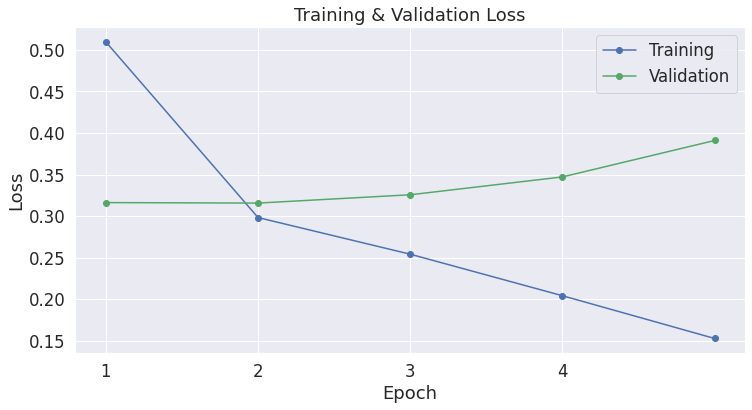

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [ ]:
!ls -l --block-size=K ./model_save/

total 499796K
-rw-r--r-- 1 root root      1K Mar 27 16:29 added_tokens.json
-rw-r--r-- 1 root root      1K Mar 27 16:29 config.json
-rw-r--r-- 1 root root    446K Mar 27 16:29 merges.txt
-rw-r--r-- 1 root root 498452K Mar 27 16:29 pytorch_model.bin
-rw-r--r-- 1 root root      1K Mar 27 16:29 special_tokens_map.json
-rw-r--r-- 1 root root      1K Mar 27 16:29 tokenizer_config.json
-rw-r--r-- 1 root root    878K Mar 27 16:29 vocab.json


In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 487M Mar 27 16:29 ./model_save/pytorch_model.bin


In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

# Generate Text

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: "Yes, indeed. _that_ is all. I know not what to think."


1: When she had taken leave, she walked into the room where Mr. Darcy was sitting with his five cousins. In a constrained manner she addressed herself to Mr. Wickham, whose civility on this occasion had been invaluable to her. "How could you ever have loved him better?"


2: "But no one can ever be sure that the house will ever be ten thousand pounds."




These aren't bad at all! Now train the model on your chosen raw text that is roughly comparable in size to pride and prejudice. 

(5 pts) Draw a figure for tracking train and validation losses. 

(5 pts) Print out some sample text from your chosen data and report 10 example generations that you think are interesting! Do your examples look like your training text?


> YOUR ANSWER HERE